# Analysis of SOAP simulated spectra



#### 1. Initializations

Imports and Auxil functions

In [1]:
# We use some interpolation routines.
from scipy import interpolate, signal, stats
from scipy.optimize import minimize_scalar
from spectres.spectral_resampling_numba import spectres_numba as sn

# Standard math and plotting.
import numpy as np, matplotlib.pyplot as plt,  pickle

# Astropy units and constants.
from astropy import units as u, constants as const

# Load some auxil routines
from auxil import gaussian_broadening, rotational_broadening, velocity_shift

Set wavelength grid and broadening kernels

In [2]:
# Set the log-sampled velocity grid
dv        = 800*u.m/u.s
c         = const.c         # speeed of light
dlam      = np.log(1+dv/c).decompose().value
wv_range  = [5000,6400] # Angstrom
wv0       = np.exp(np.arange(np.log(wv_range[0]), np.log(wv_range[1]), dlam))

------------------------------
#### 2. Load the simulation

Here we load the simulated spectra and resample it to the wavelength grid degined above.

In [3]:
# Load the simulation
with open(r"./data/SOAP_simulation.pkl", 'rb') as f:
    soap = pickle.load(f)
    
# Arrange and resample to the wavelength grid defined above
times    = soap['time']
sp_list  = [sn(wv0,soap['wv'],soap['sp'][i]) for i in np.arange(len(times))]

-------------------------
#### 3. Load the model

We use PHOENIX models to calculate the photospheric model and its temperature derivatives. 

In [4]:
# Load the PHOENIX spectrum
with open(r"./data/PHNX_model.pkl", 'rb') as f:
    phnx = pickle.load(f)
    
# Resample the spectrum to the predefined wavelength grid
model0   = sn(wv0, phnx['wv'], phnx['sp'])

# Broaden and normalize the model
Kg       = gaussian_broadening(dv=dv, N=len(wv0), R=115_000)
Kv       = rotational_broadening(dv=dv, N=len(wv0), vrot=2.0*u.km/u.s)
spn      = signal.fftconvolve(model0,Kv,mode='same') 
spn      = signal.fftconvolve(spn,Kg,mode='same') 
spn_norm = (spn-np.mean(spn))

We used the IRSOL to obtain the center-to-limb derivatives, which we noe load and resample.

In [5]:
with open(r"./data/CLV_atlas.pkl", 'rb') as f:
    clv  = pickle.load(f)

# Define the rotational and instrumental broadening kernels
Kg_hr    = gaussian_broadening(dv=dv, N=len(wv0), R=200_000)
clv_d0   = signal.fftconvolve(sn(wv0,clv['wv'],clv['derivatives'][0]),Kg_hr,mode='same')
clv_d1   = signal.fftconvolve(sn(wv0,clv['wv'],clv['derivatives'][1]),Kg_hr,mode='same')
clv_d2   = signal.fftconvolve(sn(wv0,clv['wv'],clv['derivatives'][2]),Kg_hr,mode='same')
clv_d3   = signal.fftconvolve(sn(wv0,clv['wv'],clv['derivatives'][3]),Kg_hr,mode='same')
clv_d4   = signal.fftconvolve(sn(wv0,clv['wv'],clv['derivatives'][4]),Kg_hr,mode='same')
clv_d5   = signal.fftconvolve(sn(wv0,clv['wv'],clv['derivatives'][5]),Kg_hr,mode='same')

# This is the batch of high order terms we will use later
dm       = np.array([[clv_d1], [clv_d2],[clv_d3],[clv_d4], [clv_d5]])

------------------------------
#### 4. STFT-related routines

The STFT related routines are provided explicitly below.
The first routine shows how we generate the STFT data structure.
The second routine is used to derive the score for a given velocity shift

In [6]:
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
#                Routine §1: generate the STFT data structure.
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
def generate_data_structure(data, d_models=None, window='hann', noverlap=3*2**6//4,
                            nperseg=2**6, fs=None,return_onesided=True):
    """
    This function generates the required data structure for the STFT analysis.
    It recieves a spectrum and an array of models (for example, photospheric
    model and a set of derivatives, which are assumed to be sampled on the 
    same wavelength grid. This is then used

    Input: * data          - a vector of length Nwv
           * d_models      - a matrix of size Nmodel X Nwv
           * STFT input:   - window, noverlap, nperseg, fs, and return_onesided.

    Output: * zetas, lambas - the inverse-wavelength and coarse-wavelength grids.
            * obs_block     - STFT of the data (Nzeta X Nlambda).
            * model_block   - a 3-d array the STFT of all models (Nzeta X Nmodel X Nlambda).
    """
    
    
    # Generate the data block
    zetas, lambdas, obs_block  = signal.stft(data, fs=fs, window=window, 
                                          nperseg=nperseg, noverlap=noverlap, 
                                          nfft=None, detrend=None, 
                                          return_onesided=return_onesided, 
                                          boundary='zeros', scaling='psd',
                                          padded=False, axis=-1, 
                                         )
    
    
    if d_models is None:
        return zetas, lambdas, obs_block, None
    else:
        # Initialize and fill-up the model block
        model_block = np.full((obs_block.shape[0],len(d_models), obs_block.shape[1]), np.nan, dtype=complex)                        
        for ii, m in enumerate(d_models):
            model_block[:,ii,:] = signal.stft(m, fs=fs, window=window, 
                                          nperseg=nperseg, noverlap=noverlap, 
                                          nfft=None, detrend=None, 
                                          return_onesided=return_onesided, 
                                          boundary='zeros', scaling='psd',
                                          padded=False, axis=-1, 
                                         )[-1]
        return zetas, lambdas, obs_block, model_block

In [7]:
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
#      Routine §2: calculate the log-likelihood of a given velocity shift
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
def score(vel, data,  model0, models, 
          nperseg=2**6, noverlap=3*2**6//4, dv=None, window='hann', w=1.0):
    """
    This function calculates the score described in equations (19) and (20).
    
    Input: vel       - scalar.velocity shift. Is should be in the same units as dv.
           data      - vector. STFT'ed input spectrum.
           model0    - vector. Zeroth-order photospheric mode. See equation (17).
           models    - matrix. The STFT'ed high order terms.
           w         - scalar. Typical inverse variance.
           STFT pars - nperseg, noverlap, dv, window. 
           
    Output: An array with the STFT score for the full model and for the 
            zerot-order photospheric model alone, without the high order
            terms.
    """
    
    
    # Shift the data and get the residuals
    # (This is equivalent to equation (C1) in the manuscript)
    dat_tmp  = velocity_shift(data, dv, v_shift=-vel)
    X        = np.array([np.ones_like(model0), model0])[:,2:-2]
    alpha    = np.linalg.inv(X@X.T*w)@(X*w)@dat_tmp[2:-2]
    dat_tmp -= (alpha[0] + alpha[1]*(model0))  

    
    # Generate the STFT data structure:
    zetas, lambdas, obs_block, _ = generate_data_structure(dat_tmp, None, noverlap=noverlap,
                                                                          nperseg=nperseg, fs=1/dv.value,
                                                                          window=window)

    # We remove the first and last parts of each bock, to avoid edge-effects.
    ob     = obs_block[:,1:-1]
    mdb    = models[:,:,1:-1]
    ZxxR   = np.zeros(ob.shape, dtype=complex)

    
    # The function needs to iterate over all inverse wavelengths. 
    # For each inverse wavelength, we calculate the score and aggregate it. 
    for zeta_ind, blk in enumerate(mdb):  
        y     = ob[zeta_ind,:]
        X     = np.ascontiguousarray((blk[:,:]).T)
        Xh    = np.ascontiguousarray(np.conjugate(X.T))        
        xTx   = np.ascontiguousarray(Xh@X*w)
        xTx_i = np.ascontiguousarray(np.linalg.inv(xTx))
        ctmp  = np.ascontiguousarray((xTx_i@(Xh*w)@y))        
        ZxxR[zeta_ind,:] = y - (X@ctmp) 
    
    
    # Here we calculate the score
    int_factor = (zetas[1]-zetas[0])*(lambdas[1]-lambdas[0])*(1/dv.value)
    E_Zxx      = -np.sum((ZxxR.real**2 + ZxxR.imag**2)*int_factor)
    E_Zxx0     = -np.sum((ob.real**2 + ob.imag**2)*int_factor)
    
    return [E_Zxx, E_Zxx0]

------------------------
#### 5. Numerical experiment

Now we add a sinewave to the data and check whether we can find it..

In [8]:
# Generate the model matrix for the high order terms.
_, _, _, mdl = generate_data_structure(spn_norm, dm,fs=1/0.8)

In [9]:
from tqdm import tqdm

# Initialize the vectors
snr          = 100
Nobs         = len(sp_list)
RVs, RVs0    = np.full(Nobs, np.nan), np.full(Nobs, np.nan)
RVse, RVs0e  = np.full(Nobs,np.nan),  np.full(Nobs,np.nan)


# Iterate through the observations
# --------------------------------
for obs_n in tqdm(np.arange(Nobs)):    
    
    # Assign a simulated velocity shift to the observation
    ttmp      = times[obs_n]
    vtmp      = 0.3*np.sin(2*np.pi*(ttmp-times[0])/17)*u.m/u.s
    
    # Load the n-th simulation, shift it, normalize it, and add some white noise.
    dat       = sp_list[obs_n]/np.median(sp_list[obs_n])
    dat       = velocity_shift(dat, dv, v_shift=vtmp)
    noise_std = np.sqrt(np.var(dat)/snr**2)
    dat       = (dat - np.mean(dat)) + np.random.normal(size=len(dat))*noise_std

    # Get the RV
    sc  = lambda x: -1*score(x*const.c, dat, spn_norm, mdl, dv=dv, w=1/noise_std**2)[0]
    sc0 = lambda x: -1*score(x*const.c, dat, spn_norm, mdl, dv=dv, w=1/noise_std**2)[1]
    res = minimize_scalar(sc, 
                            bounds=(-400/const.c.value, 400/const.c.value),  
                            method='bounded',  options={'xatol': 1e-13})

    res0 = minimize_scalar(sc0, 
                            bounds=(-400/const.c.value, 400/const.c.value),  
                            method='bounded',  options={'xatol': 1e-13})


    # Calculate the uncertainty with some spline aroud the best score
    xx        = np.linspace(res.x*const.c.value-1,res.x*const.c.value+1,20)/const.c.value
    yy        = -0.5*np.array([sc(x) for x in xx])*noise_std**(-2) 
    y_spl     = interpolate.UnivariateSpline(xx,yy,s=0,k=4)
    score_vel  = y_spl.derivative(n=1).roots()
    score_se   = (-1/y_spl.derivative(n=2)(score_vel))**0.5
    
    # The same, but now the velocity based on the score of the zero term only
    xx0       = np.linspace(res0.x*const.c.value-1,res.x*const.c.value+1,20)/const.c.value
    yy0       = -0.5*np.array([sc0(x) for x in xx0])*noise_std**(-2)
    y0_spl    = interpolate.UnivariateSpline(xx0,yy0,s=0,k=4)
    score0_vel = y0_spl.derivative(n=1).roots()
    score0_se  = (-1/y0_spl.derivative(n=2)(score0_vel))**0.5
    
    # Keep the velocity and its derived uncertainty
    RVs[obs_n]  = score_vel[0]*const.c.value
    RVse[obs_n] = score_se[0]*const.c.value
    RVs0[obs_n]  = score0_vel[0]*const.c.value
    RVs0e[obs_n] = score0_se[0]*const.c.value

100%|██████████| 249/249 [18:15<00:00,  4.40s/it]


In [10]:
soap_rv = np.genfromtxt('SOAP_RVs.csv', dtype=float, delimiter=',', names=True) 
t   =  np.array([x[0] for x in soap_rv])
srv =  np.array([x[1] for x in soap_rv])
srv += 0.3*np.sin(2*np.pi*(t-t[0])/17)

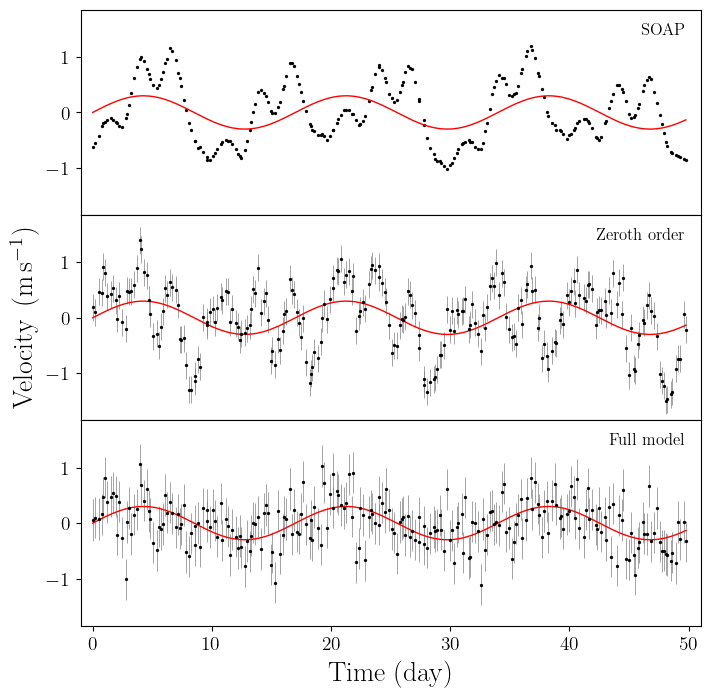

In [11]:
# Sime plotting definitions
plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica"]})
plt.rcParams['font.size'] = 14

fig  = plt.figure(figsize=(8,8))
grid = plt.GridSpec(3, 1, figure=fig, wspace=0.5, hspace=0.0)


ax1 = plt.subplot(grid[0, 0])
plt.plot(t,srv-srv.mean(),'.k',markersize=2.7,)
plt.plot(times, 0.3*np.sin(2*np.pi*(times-times[0])/17)*u.m/u.s,'-r',linewidth=1)
plt.text(0.975, 0.9, r'${\rm SOAP}$', horizontalalignment='right',
         verticalalignment='center', transform = ax1.transAxes,fontsize=12)
ax1.set_xticks([])
ax1.set_xticks([], minor=True)
ax1.set_ylim([-1.85,1.85])
ax1.set_xlim([-1,51])

ax2 = plt.subplot(grid[1, 0])
plt.errorbar(np.array(times),np.array(RVs0)-np.nanmean(RVs0),yerr=RVs0e, 
             markersize=2.7, elinewidth=0.5, fmt='.k', ecolor='grey')
plt.plot(times, 0.3*np.sin(2*np.pi*(times-times[0])/17)*u.m/u.s,'-r',linewidth=1)
_ = ax2.set_ylabel(r'${\rm Velocity}$\, ${\rm(m\, s^{-1})}$', labelpad=5, fontsize=20)
plt.text(0.975, 0.9, r'${\rm Zeroth \,\, order}$', horizontalalignment='right',
         verticalalignment='center', transform = ax2.transAxes,fontsize=12)
ax2.set_xticks([])
ax2.set_xticks([], minor=True)
ax2.set_ylim([-1.85,1.85])
ax2.set_xlim([-1,51])

ax3  = plt.subplot(grid[2, 0])
plt.errorbar(np.array(times),np.array(RVs)-np.nanmean(RVs),yerr=RVse, 
             markersize=2.7, elinewidth=0.5, fmt='.k', ecolor='grey')
plt.plot(times, 0.3*np.sin(2*np.pi*(times-times[0])/17)*u.m/u.s,'-r',linewidth=1)
plt.text(0.975, 0.9, r'${\rm Full \,\, model}$', horizontalalignment='right',
         verticalalignment='center', transform = ax3.transAxes,fontsize=12)
ax3.set_ylim([-1.85,1.85])
ax3.set_xlim([-1,51])

_ = ax3.set_xlabel(r'$\rm{Time}$ $(\rm{day})$', labelpad=5, fontsize=20)

In [12]:
np.std(RVs-RVs.mean()-0.3*np.sin(2*np.pi*(times-times[0])/17))

0.3631289318075221